## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_TAU',
            'B0_TAUERR',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV'
            ]

In [5]:
l0_cut =  '((abs(1115.683-varLambda0MassHypo_ppluspiminus)>17)|piplus_ProbNNp<0.4)&((abs(1115.683-varLambda0MassHypo_pminuspiplus)>17)|(piminus_ProbNNp<0.4))'

In [6]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches,where=l0_cut, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [7]:
signal_dataframe_wrongPV['Delta_TAU'] = signal_dataframe_wrongPV['B0_TAU'] -signal_dataframe_wrongPV['B0_TRUETAU']

In [8]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key='Bd2JpsiKS')

In [9]:
'''test_1 = pd.DataFrame()
test_2 = pd.DataFrame()
test_3 = pd.DataFrame()
for row in signal_dataframe_wrongPV.itertuples():
    print("yes")
pv_num = signal_dataframe_wrongPV['runNumber'].unique()
pv_num = np.array(pv_num)
print(len(pv_num))
for nums in pv_num:
    num = str(nums)
    test_1 = signal_dataframe_wrongPV.query('runNumber'+'=='+num)
    evt_num = test_1['eventNumber'].unique()
    evt_num = np.array(evt_num)
    print(len(evt_num))
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1) 
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1)'''

'test_1 = pd.DataFrame()\ntest_2 = pd.DataFrame()\ntest_3 = pd.DataFrame()\nfor row in signal_dataframe_wrongPV.itertuples():\n    print("yes")\npv_num = signal_dataframe_wrongPV[\'runNumber\'].unique()\npv_num = np.array(pv_num)\nprint(len(pv_num))\nfor nums in pv_num:\n    num = str(nums)\n    test_1 = signal_dataframe_wrongPV.query(\'runNumber\'+\'==\'+num)\n    evt_num = test_1[\'eventNumber\'].unique()\n    evt_num = np.array(evt_num)\n    print(len(evt_num))\n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1) \n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1)'

In [10]:
#test.shape,signal_dataframe_wrongPV.query('idxPV==0').shape,signal_dataframe_wrongPV.shape

### Function to calculate the FOMs

### Configure  and define cuts 

In [11]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
mass_var_name = 'B0_FitDaughtersConst_M'
cuttype = 'Delta_TAU'#'B0_TAUERR'#

cuts = np.linspace(0.00001,0.02,100) #(0,20,10)    #(0,0.001,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [12]:
def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    timeres_power_bestPV = 0
    timeres_power_randomPV = 0
    

    
    tagomega = np.array(best_pv['B0_TAGOMEGA_OS'])
    tag1 = np.array(best_pv['B0_TAGDECISION_OS'])
    time = np.array(best_pv['B0_TAU']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
    
    tagomega_wrong = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1_wrong = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time_wrong = np.array(data_fit_cut['B0_TAU']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))
    
    range_best_pv = best_pv.shape[0]-1
    print(range_best_pv)
    
    for i in range(range_best_pv):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight

        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power_bestPV    += timeerror_dilution*signal_weight
         
    print('+++++++++++++++++++++++++')
    print(cut)
    timeerror_dilution_theory = math.exp(-(delta_m*cut)**2)

    timeres_power_bestPV /= signal_sum
    #timeres_power_wrong /= signal_sum_wrong

    
    fomname_to_value = {
        'TimeresPower_bestPV' : timeres_power_bestPV,
        'TimeresTheory': timeerror_dilution_theory,
    }
    #return fomname_to_value

    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong =  1 
        cbkg_weight_wrong   =  1 
        mistag_wrong        =  tagomega_wrong[i] 
        tag_wrong           =  tag1_wrong[i]
        decaytime_wrong     =  time_wrong[i]
        timeerror_wrong     =  error_wrong[i]
        
        
        signal_sum_wrong    += signal_weight_wrong
        signal_sumw2_wrong  += signal_weight_wrong**2
        
        timeerror_dilution_wrong = math.exp(-(delta_m*timeerror_wrong)**2)
    
        timeres_power_randomPV     += timeerror_dilution_wrong *signal_weight_wrong 
        
    timeres_power_randomPV /= signal_sum_wrong  
    fomname_to_value.update({'TimeresPower_randomPV' : timeres_power_randomPV})
    
    return fomname_to_value

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


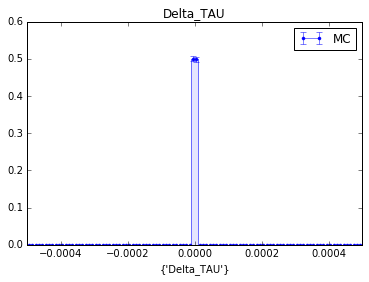

In [13]:
sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

cuttype = 'Delta_TAU'
cut = 0.000001

p = Plotter('/home/chasenberg/plots/selection/')
p.create_plots(signal_dataframe_wrongPV.query('{0}>-{1}&{0}<{1}'.format(cuttype,cut)).query('idxPV==0'),'Delta_TAU',component_labels=['MC'])
p['Delta_TAU'].set_range(-0.0005,0.0005)
#bdt_plot.plot()
p.plot()

In [22]:
from ROOT import RooArgList
import subprocess, os
import time

x=None
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}<{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>-{1}&{0}<{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    best_pv = signal_dataframe_wrongPV.query('{0}>-{1}&{0}<{1}'.format(cuttype,cut)).query('idxPV==0')
    #data_fit_cut = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6')
    #print("The size of the sample is:")
    #print(data_fit_cut['Delta_TAU'].min())
    #data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>15').to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
   
    
    foms = calculate_foms(data_fit_cut,best_pv)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut Delta_TAU<1e-05
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
107184
+++++++++++++++++++++++++
1e-05
INFO: Finish Calculation
INFO: Starting to test cut Delta_TAU<0.00021191919191919194
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
497915
+++++++++++++++++++++++++
0.000211919191919
INFO: Finish Calculation
INFO: Starting to test cut Delta_TAU<0.0004138383838383839
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
499579
+++++++++++++++++++++++++
0.000413838383838
INFO: Finish Calculation
INFO: Starting to test cut Delta_TAU<0.0006157575757575758
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
499869


In [23]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

### Plot FOMs

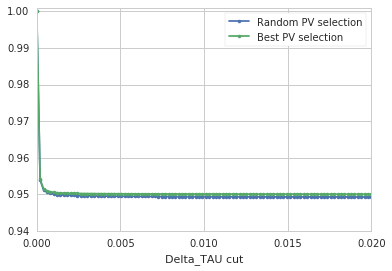

In [24]:
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
#foms_to_plot["TaggingPower"] = r"Flavour Tagging"
foms_to_plot["TimeresPower_bestPV"] = "Best PV selection"
foms_to_plot["TimeresPower_randomPV"]   = "Random PV selection"
#foms_to_plot["BsFOM"]        = "$X_i$-term"
#foms_to_plot["BdFOM_p"]      = "FOM ${}_{B^0_d}$"
#foms_to_plot["BdFOM"]        = "FOM"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    values=ys[parameter]
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("Delta_TAU cut")
'''values_EffSigSize=ys['EffSigSize']
values_TimeresPower=ys['TimeresPower']
values_TaggingPower=ys['TaggingPower']
values_BdFOM_p=ys['BdFOM_p']
values_BdFOM=ys['BdFOM']


plt.errorbar(x,values_EffSigSize+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[0])
plt.errorbar(x,values_TimeresPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[1])
plt.errorbar(x,values_TaggingPower+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[2])
plt.errorbar(x,values_BdFOM_p+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[3])
plt.errorbar(x,values_BdFOM+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter],color=current_palette[4])
plt.xlabel("BDT Schnitt")'''
plt.gca().set_ylim(0.94,1.001)
plt.gca().set_xlim(0.0000000001,0.02)
plt.legend(loc='best')
plt.savefig(subdir + '/dilution_randomsel_no_minipchi2_cut.pdf')
plt.show()

In [25]:
print(ys['TimeresPower_bestPV'])

[ 1.          0.95411962  0.95153811  0.95098799  0.9506951   0.95053922
  0.95043659  0.95037769  0.95033209  0.95030359  0.9502827   0.950258
  0.95022571  0.95020862  0.95019532  0.95019152  0.95018583  0.95017823
  0.95016493  0.95015734  0.95015734  0.95015164  0.95014974  0.95014594
  0.95014024  0.95013455  0.95012695  0.95012315  0.95011746  0.95011556
  0.95010986  0.95010986  0.95010416  0.95010416  0.95010037  0.95009467
  0.95009467  0.95009087  0.95009087  0.95008707  0.95008707  0.95008517
  0.95007948  0.95007758  0.95007378  0.95007378  0.95007378  0.95007188
  0.95006998  0.95006809  0.95006429  0.95006429  0.95006429  0.95006429
  0.95006239  0.95006049  0.95005479  0.95005479  0.9500529   0.9500491
  0.9500491   0.9500491   0.9500453   0.9500453   0.9500415   0.9500415
  0.9500396   0.9500396   0.9500396   0.9500396   0.95003771  0.95003771
  0.95003391  0.95003391  0.95003201  0.95003011  0.95002821  0.95002821
  0.95002821  0.95002821  0.95002821  0.95002821  0.950

In [26]:
print(ys['TimeresPower_randomPV'])

[ 1.          0.95395368  0.95120116  0.95057087  0.95023695  0.95004164
  0.94991464  0.94983694  0.94978199  0.9497403   0.94971378  0.949674
  0.94963611  0.9496058   0.94959065  0.94958307  0.94956982  0.94955656
  0.94953952  0.94952058  0.9495149   0.94950164  0.94949407  0.94948649
  0.94947702  0.94946756  0.94945619  0.94945051  0.94944294  0.94943726
  0.94943158  0.94942969  0.94941833  0.94941833  0.94941265  0.94940129
  0.9493975   0.94939371  0.94939371  0.94938993  0.94938993  0.94938425
  0.94937667  0.94937478  0.94937099  0.9493691   0.9493691   0.94936721
  0.94936342  0.94935964  0.94935396  0.94935206  0.94935206  0.94934828
  0.94934449  0.94934071  0.94933313  0.94933124  0.94932935  0.94932556
  0.94932178  0.94932178  0.94931799  0.9493161   0.94931231  0.94931231
  0.94931042  0.94931042  0.94931042  0.94931042  0.94930663  0.94930663
  0.94930285  0.94930285  0.94929906  0.94929717  0.94929527  0.94929527
  0.94929527  0.94929527  0.94929527  0.94929527  0.9

In [27]:
print(x)

[  1.00000000e-05   2.11919192e-04   4.13838384e-04   6.15757576e-04
   8.17676768e-04   1.01959596e-03   1.22151515e-03   1.42343434e-03
   1.62535354e-03   1.82727273e-03   2.02919192e-03   2.23111111e-03
   2.43303030e-03   2.63494949e-03   2.83686869e-03   3.03878788e-03
   3.24070707e-03   3.44262626e-03   3.64454545e-03   3.84646465e-03
   4.04838384e-03   4.25030303e-03   4.45222222e-03   4.65414141e-03
   4.85606061e-03   5.05797980e-03   5.25989899e-03   5.46181818e-03
   5.66373737e-03   5.86565657e-03   6.06757576e-03   6.26949495e-03
   6.47141414e-03   6.67333333e-03   6.87525253e-03   7.07717172e-03
   7.27909091e-03   7.48101010e-03   7.68292929e-03   7.88484848e-03
   8.08676768e-03   8.28868687e-03   8.49060606e-03   8.69252525e-03
   8.89444444e-03   9.09636364e-03   9.29828283e-03   9.50020202e-03
   9.70212121e-03   9.90404040e-03   1.01059596e-02   1.03078788e-02
   1.05097980e-02   1.07117172e-02   1.09136364e-02   1.11155556e-02
   1.13174747e-02   1.15193939e-02

Plotting of B0_TAU and Delta_TAU

In [28]:
delta_tau = RooRealVar("Delta_TAU", "delta_tau", 0,2, "ps")
b0_tauerr = RooRealVar("B0_TAUERR", "delta_tau", 0,2, "ps")

dataset_file_name =  '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root'
data = ROOT.TFile(dataset_file_name)
tree_data = data.Get('Bd2JpsiKS') 
ntupleVarSet =  RooArgSet(delta_tau,b0_tauerr) 
dataset = RooDataSet('data','data',tree_data,ntupleVarSet)

In [29]:
# Prepare frame
%matplotlib inline  
import ROOT

frame = delta_tau.frame(ROOT.RooFit.Bins(100))

dataset.plotOn(frame, ROOT.RooFit.Name("data1"))
text_size = 0.035
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7,0.85,0.85)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(frame.findObject('data1'), "Delta_Tau", "p");
#legend.AddEntry(frame.findObject('sig_pdf_ext'), 'Massenfunktion', 'kBluw')

legend.SetTextSize(text_size)
frame.GetYaxis().SetTitle(frame.GetYaxis().GetTitle().replace("Events", "Kandidaten"))
# Plot pulls
#can, _ = plot_pulls('Hallo', frame, legend=legend, logy=False)#, latex=latex)
can = ROOT.TCanvas("my_canvas","Plotting Canvas",150,10,990,660)
can.SaveAs("/home/chasenberg/plots/wrongpv_cuttuning/delta_tau.pdf")
can  # To display plot in notebooks

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: my_canvas


<ROOT.TCanvas object ("my_canvas") at 0xc651d60>